In [ ]:
## Run and restart runtime

In [ ]:
!pip install pycaret[full] boruta==0.3

In [ ]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table
import pandas as pd

project = '' # Project ID inserted based on the query results selected to explore
location = '' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

In [ ]:
query="""
with
multiclass_outcomes_cte as
(
select * except(first_appointment_date, total_completed_appointments) from temp_outcomes
),
clinician_experience_hours_cte as
(
select p.member_user_id, sum(session_length)/60 as clinician_experience_hours
from dbt_analytics.int_member_profile p join dbt_analytics.user u on p.clinician_user_id = u.user_id
left join dbt_analytics.fct_appointment a
on u.user_email = a.clinician_email and a.appointment_date < p.first_appointment_date
group by p.member_user_id
),
hire_date_cte as
(
select user_id as clinician_user_id, hire_date
from dbt_analytics.dim_user
where hire_date is not null
),
diagnosis_code_cte as
(
select member_user_id, first_episode_type, from dbt_analytics.mrt_member_aggerate
),
comorbid_cte as
(
select member_user_id, co_morbid_dx from dbt_analytics.int_comorbid_diagnosis
),
members_12_sessions_by_week_17_cte as
(
select
member_user_id,
max(visits_total) as total_visits_week_17
from dbt_analytics.int_member_profile_weekly
where week <= 17
and first_appointment_date >= '2022-01-01' and first_appointment_date < '2023-01-01'
group by member_user_id
)
select s.*, total_visits_week_17 >= 12 as is_adherent,  p.* except(member_user_id), w.* except(member_user_id), d.first_episode_type, ifnull(c.co_morbid_dx,"No") as co_morbid, p.first_appointment_date, h.hire_date, date_diff(p.first_appointment_date, h.hire_date, day) as first_appt_employment_days, e.clinician_experience_hours, m.*
from members_12_sessions_by_week_17_cte s
join dbt_analytics.int_member_profile p
on s.member_user_id = p.member_user_id
join  dbt_analytics.int_member_profile_weekly w
on s.member_user_id = w.member_user_id and w.week=3
left join diagnosis_code_cte d
on s.member_user_id = d.member_user_id
left join dbt_analytics.int_comorbid_diagnosis c
on s.member_user_id = c.member_user_id
left join hire_date_cte h
on p.clinician_user_id = h.clinician_user_id
left join clinician_experience_hours_cte e
on s.member_user_id = e.member_user_id
left join multiclass_outcomes_cte m
on s.member_user_id = m.member_user_id
"""

In [ ]:
job_config = bigquery.QueryJobConfig(default_dataset = "-bigquery.dbt_analytics")
data_df = client.query(query, job_config=job_config).to_dataframe()

In [ ]:
df = pd.DataFrame(data_df)

In [ ]:
print(df.shape)

(21537, 112)


In [ ]:
df.describe()

,member_user_id,total_visits_week_17,clinician_user_id,age_at_therapy_start,total_completed_appointments,bg_ocd_criteria_time_years,pre_therapy_posts,pre_therapy_appopens,pre_therapy_cancellations,pre_therapy_member_messages,...,exposures,erp,erp_minutes,first_appt_employment_days,clinician_experience_hours,member_user_id_1,has_visits_less_4,has_visits_4_to_11,is_partial_response,has_break_in_care
count,21537.0,21537.0,20935.0,21536.0,21537.0,21537.000000,6948.0,21509.0,21125.0,21537.0,...,21537.0,21537.0,21537.000000,20924.0,19794.000000,21534.0,21534.0,21534.0,21534.0,21534.0
mean,240257.110507,11.142035,178911.965942,27.736906,16.351256,0.000975,2.839954,7.88628,0.220213,1.420996,...,1.36421,0.219761,2.941785,296.404081,631.614062,240262.357156,0.065849,0.370391,0.122922,0.206557
std,52240.455497,6.064952,57644.323253,12.788565,12.373475,0.065707,15.27523,12.807704,0.550755,3.057004,...,3.702944,1.289799,55.716486,248.064651,522.933072,52239.791592,0.248024,0.482921,0.328355,0.404844
min,678.0,1.0,52369.0,0.0,2.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,-468.0,1.000000,678.0,0.0,0.0,0.0,0.0
25%,224692.0,6.0,127836.0,21.0,7.0,0.000000,0.0,2.0,0.0,0.0,...,0.0,0.0,0.000000,99.0,171.500000,224692.0,0.0,0.0,0.0,0.0
50%,250453.0,11.0,187227.0,26.0,13.0,0.000000,0.0,5.0,0.0,0.0,...,0.0,0.0,0.000000,259.0,543.250000,250457.0,0.0,0.0,0.0,0.0
75%,274223.0,15.0,216854.0,33.0,22.0,0.000000,1.0,10.0,0.0,2.0,...,1.0,0.0,0.000000,451.0,974.750000,274225.25,0.0,1.0,0.0,0.0
max,305906.0,47.0,336523.0,1025.0,107.0,5.000000,508.0,351.0,8.0,92.0,...,105.0,61.0,3631.983333,1159.0,2974.250000,305906.0,1.0,1.0,1.0,1.0


In [ ]:
print(df.columns)

Index(['member_user_id', 'total_visits_week_17', 'is_adherent',
       'first_appointment_prev_30_day_date', 'first_appointment_date',
       'last_appointment_date', 'member_state', 'member_country_code',
       'clinician_user_id', 'clinician_employment_status',
       ...
       'co_morbid', 'first_appointment_date_2', 'hire_date',
       'first_appt_employment_days', 'clinician_experience_hours',
       'member_user_id_1', 'has_visits_less_4', 'has_visits_4_to_11',
       'is_partial_response', 'has_break_in_care'],
      dtype='object', length=112)


# Preprocessing

In [ ]:
import numpy as np

In [ ]:
def get_region(state):
    northeast_states = ["Connecticut", "Delaware", "Maryland", "Massachusetts", "Maine", "New Hampshire", "New Jersey", "New York", "Pennsylvania", "Rhode Island", "Vermont", "Virginia", "West Virginia", "District Of Columbia"]
    southeast_states = ["Alabama", "Florida", "Georgia", "Kentucky", "Louisiana", "Mississippi", "North Carolina", "South Carolina", "Tennessee"]
    midwest_states = ["Arkansas", "Illinois", "Indiana", "Iowa", "Kansas", "Michigan", "Minnesota", "Missouri", "Nebraska", "North Dakota", "Ohio", "South Dakota", "Wisconsin"]
    pacific_states = ["California", "Hawaii", "Idaho", "Nevada", "Oregon", "Washington", "Alaska"]
    canada_states = ["Alberta", "British Columbia", "Manitoba", "New Brunswick", "Nova Scotia", "Ontario", "Quebec", "Saskatchewan"]
    other_countries = ["Dubai", "Kärnten", "Not in the US", "SINGAPORE", "Spain","UNK"]

    if state in northeast_states:
        return "Northeast"
    elif state in southeast_states:
        return "Southeast"
    elif state in midwest_states:
        return "Midwest"
    elif state in pacific_states:
        return "Pacific"
    elif state in canada_states:
        return "Canada"
    elif state in other_countries:
        return "Other Country"
    else:
        return "region"

df['region'] = df['member_state'].apply(get_region)

In [ ]:
# A new feature that tells us how much therapy a therapist does per day employed
df['experience_ratio'] = df['clinician_experience_hours']/df['first_appt_employment_days']

In [ ]:
df['has_break_in_care'] = df['has_break_in_care'].astype('Int64')
df['is_adherent'] = df['is_adherent'].astype('Int64')

In [ ]:
df['is_adherent'] = df['is_adherent'].replace({'True': 1, 'False': 0})

In [ ]:
df['is_adherent'].value_counts()

0    11957
1     9580
Name: is_adherent, dtype: Int64

In [ ]:
df['has_break_in_care'].value_counts()

0    17086
1     4448
Name: has_break_in_care, dtype: Int64

In [ ]:
result = df[(df['is_adherent'] == 1) & (df['has_break_in_care'] == 1)]

print(result)
# 439 rows are both adherent and have break in care which shouldn't be. Overwriting the 439 as non-adherent instead

In [ ]:
df.loc[result.index, 'is_adherent'] = 0

In [ ]:
result2 = df[(df['is_adherent'] == 1) & (df['has_break_in_care'] == 1)]

print(result2)
# Now 0 rows share

Empty DataFrame
Columns: [member_user_id, total_visits_week_17, is_adherent, first_appointment_prev_30_day_date, first_appointment_date, last_appointment_date, member_state, member_country_code, clinician_user_id, clinician_employment_status, clinician_licensing_level, clinician_star_rating, current_clinician_role, dob, age_at_therapy_start, total_completed_appointments, member_gender, bg_medication_status, bg_ocd_criteria_time_years, billing_plan, pre_therapy_posts, pre_therapy_appopens, pre_therapy_cancellations, pre_therapy_member_messages, pre_therapy_clinician_messages, week, first_appointment_date_1, last_appointment_date_1, week_start, week_end, visits_total, docs_count, docs_severity, first_docs_severity, docs_symmetry, first_docs_symmetry, docs_contamination, first_docs_contamination, docs_responsibility, first_docs_responsibility, docs_unacceptable_thoughts, first_docs_unacceptable_thoughts, qles_count, qles_total, first_qles_total, diamond_count, diamond_distress_score, firs

In [ ]:
df['is_adherent'].value_counts(dropna=False)

0       12394
1        9143
<NA>        0
Name: is_adherent, dtype: Int64

In [ ]:
df['has_break_in_care'] = df['has_break_in_care'].astype('float')

In [ ]:
df['has_break_in_care'].fillna(np.nan, inplace=True)

In [ ]:
df['has_break_in_care'].value_counts(dropna=False)

0.0    17086
1.0     4448
NaN        3
Name: has_break_in_care, dtype: int64

In [ ]:
missing_rows = df[df['has_break_in_care'].isna()]

print(missing_rows)
# the 3 missing are adherent

      member_user_id  total_visits_week_17  is_adherent  \
1317          144819                    18            1   
3875          217030                    15            1   
9865          245941                    17            1   

     first_appointment_prev_30_day_date first_appointment_date  \
1317                         2022-02-01             2022-03-03   
3875                         2021-12-11             2022-01-10   
9865                         2022-04-01             2022-05-01   

     last_appointment_date member_state member_country_code  \
1317            2022-10-11     Michigan                  US   
3875            2022-06-06     New York                  US   
9865            2022-10-20       Quebec                  CA   

      clinician_user_id clinician_employment_status  ...   hire_date  \
1317              52369                    Fulltime  ...  2019-09-19   
3875             193541                    Fulltime  ...  2021-11-08   
9865               <NA>      

In [ ]:
df['step_one_class'] = np.where(df['is_adherent'] == 0, 0,
                                np.where(df['is_adherent'] == 1, 1, np.nan))

In [ ]:
# Checking value counts
df['step_one_class'].value_counts(dropna=False)

0.0    12394
1.0     9143
Name: step_one_class, dtype: int64

In [ ]:
df['step_one_class'] = np.where(df['has_break_in_care'] == 1, 2, df['step_one_class'])

In [ ]:
df['step_one_class'].value_counts(dropna=False)
# 0 = non-adherent
# 1 = adherent
# 2 = has break in care

1.0    9143
0.0    7946
2.0    4448
Name: step_one_class, dtype: int64

In [ ]:
df['co_morbid'] = df['co_morbid'].replace({'Yes': 1, 'No': 0})

## Prep dataframe for analysis

In [ ]:
df0 = df[['step_one_class', 'member_country_code', 'clinician_user_id',
       'clinician_employment_status', 'clinician_licensing_level',
       'clinician_star_rating', 'current_clinician_role',
       'age_at_therapy_start', 'member_gender', 'bg_ocd_criteria_time_years',
       'billing_plan', 'pre_therapy_posts', 'pre_therapy_appopens',
       'pre_therapy_cancellations', 'pre_therapy_member_messages',
       'pre_therapy_clinician_messages', 'visits_total', 'docs_count',
       'docs_severity', 'first_docs_severity', 'docs_contamination',
       'first_docs_contamination', 'docs_symmetry', 'first_docs_symmetry', 'docs_responsibility', 'first_docs_responsibility', 'docs_unacceptable_thoughts', 'first_docs_unacceptable_thoughts',
       'qles_count', 'qles_total',
       'first_qles_total', 'diamond_count', 'diamond_distress_score',
       'first_diamond_distress_score', 'diamond_functional_score',
       'first_diamond_functional_score', 'diamond_funct_imprmnt_avg',
       'dass_count', 'dass_anxiety', 'first_dass_anxiety', 'dass_total',
       'first_dass_total', 'dass_depression', 'first_dass_depression',
       'dass_stress', 'first_dass_stress', 'visits', 'cancellations_total',
       'cancellations', 'member_messages_total', 'clinician_messages_total',
       'member_messages', 'clinician_messages', 'posts_total', 'posts',
       'ratings_count_total', 'ratings_average', 'ratings_latest',
       'ratings_count', 'opens', 'obsessions_total', 'exposures_total',
       'erp_total', 'erp_minutes_total', 'obsessions', 'exposures', 'erp',
       'erp_minutes', 'region', 'first_episode_type', 'bg_medication_status', 'co_morbid','first_appt_employment_days','experience_ratio']]
df0.describe()

,step_one_class,clinician_user_id,age_at_therapy_start,bg_ocd_criteria_time_years,pre_therapy_posts,pre_therapy_appopens,pre_therapy_cancellations,pre_therapy_member_messages,pre_therapy_clinician_messages,visits_total,...,exposures_total,erp_total,erp_minutes_total,obsessions,exposures,erp,erp_minutes,co_morbid,first_appt_employment_days,experience_ratio
count,21537.000000,20935.0,21536.0,21537.000000,6948.0,21509.0,21125.0,21537.0,21537.0,21537.0,...,21537.0,21537.0,21537.000000,21537.0,21537.0,21537.0,21537.000000,21537.000000,20924.0,20924.0
mean,0.837582,178911.965942,27.736906,0.000975,2.839954,7.88628,0.220213,1.420996,3.72531,3.469053,...,3.09811,0.3754,4.802945,0.610856,1.36421,0.219761,2.941785,0.696569,296.404081,<NA>
std,0.741027,57644.323253,12.788565,0.065707,15.27523,12.807704,0.550755,3.057004,3.994557,1.503334,...,5.766127,2.023014,69.504261,1.539439,3.702944,1.289799,55.716486,0.459751,248.064651,<NA>
min,0.000000,52369.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,-468.0,<NA>
25%,0.000000,127836.0,21.0,0.000000,0.0,2.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,99.0,<NA>
50%,1.000000,187227.0,26.0,0.000000,0.0,5.0,0.0,0.0,2.0,3.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000,259.0,<NA>
75%,1.000000,216854.0,33.0,0.000000,1.0,10.0,0.0,2.0,5.0,4.0,...,4.0,0.0,0.000000,0.0,1.0,0.0,0.000000,1.000000,451.0,<NA>
max,2.000000,336523.0,1025.0,5.000000,508.0,351.0,8.0,92.0,90.0,13.0,...,105.0,82.0,4392.400000,46.0,105.0,61.0,3631.983333,1.000000,1159.0,<NA>


In [ ]:
print(df0.columns)

Index(['step_one_class', 'member_country_code', 'clinician_user_id',
       'clinician_employment_status', 'clinician_licensing_level',
       'clinician_star_rating', 'current_clinician_role',
       'age_at_therapy_start', 'member_gender', 'bg_ocd_criteria_time_years',
       'billing_plan', 'pre_therapy_posts', 'pre_therapy_appopens',
       'pre_therapy_cancellations', 'pre_therapy_member_messages',
       'pre_therapy_clinician_messages', 'visits_total', 'docs_count',
       'docs_severity', 'first_docs_severity', 'docs_contamination',
       'first_docs_contamination', 'docs_symmetry', 'first_docs_symmetry',
       'docs_responsibility', 'first_docs_responsibility',
       'docs_unacceptable_thoughts', 'first_docs_unacceptable_thoughts',
       'qles_count', 'qles_total', 'first_qles_total', 'diamond_count',
       'diamond_distress_score', 'first_diamond_distress_score',
       'diamond_functional_score', 'first_diamond_functional_score',
       'diamond_funct_imprmnt_avg', 'das

In [ ]:
print(df0['region'].dtypes)


object


In [ ]:
df0 = df0.dropna(subset=['step_one_class'])

# Modeling

In [ ]:
import pycaret
pycaret.__version__

'3.0.2'

In [ ]:
# import pycaret classification and init setup
from pycaret.classification import *
s = setup(df0, target = 'step_one_class', session_id = 123)

,Description,Value
0,Session id,123
1,Target,step_one_class
2,Target type,Multiclass
3,Original data shape,"(21537, 74)"
4,Transformed data shape,"(21537, 98)"
5,Transformed train set shape,"(15075, 98)"
6,Transformed test set shape,"(6462, 98)"
7,Ordinal features,3
8,Numeric features,63
9,Categorical features,10


In [ ]:
# Step 1
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7629,0.9157,0.7629,0.7688,0.7590,0.6225,0.6262,6.2920
et,Extra Trees Classifier,0.7575,0.9155,0.7575,0.7651,0.7532,0.6134,0.6177,5.9900
xgboost,Extreme Gradient Boosting,0.7489,0.8854,0.7489,0.7481,0.7453,0.6022,0.6042,24.5720
catboost,CatBoost Classifier,0.7322,0.8750,0.7322,0.7321,0.7279,0.5747,0.5773,33.9960
lightgbm,Light Gradient Boosting Machine,0.7159,0.8623,0.7159,0.7160,0.7106,0.5479,0.5509,3.2190
dt,Decision Tree Classifier,0.6965,0.7649,0.6965,0.6968,0.6964,0.5265,0.5267,2.0240
gbc,Gradient Boosting Classifier,0.6172,0.7809,0.6172,0.6132,0.6050,0.3850,0.3897,25.4480
ada,Ada Boost Classifier,0.5777,0.7339,0.5777,0.5703,0.5686,0.3259,0.3284,3.2490
knn,K Neighbors Classifier,0.5622,0.7267,0.5622,0.5599,0.5545,0.3032,0.3063,1.9190
lda,Linear Discriminant Analysis,0.5543,0.7176,0.5543,0.5447,0.5412,0.2837,0.2872,1.1590


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

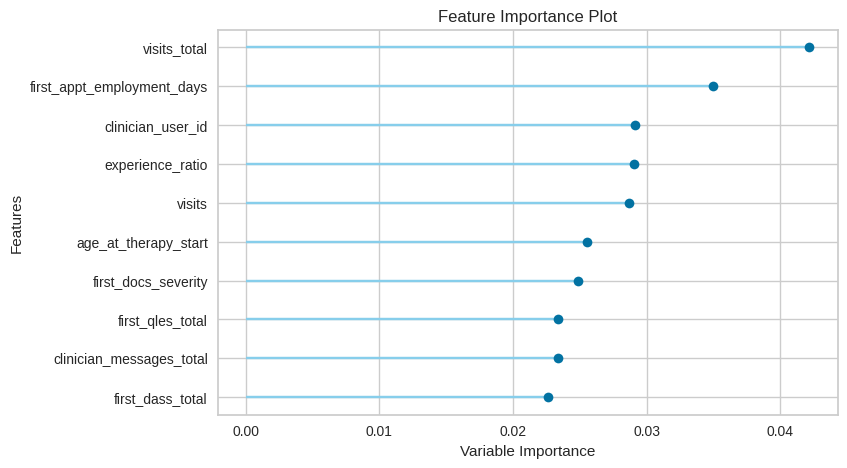

In [ ]:
plot_model(best, plot = 'feature')

In [ ]:
# train model
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7591,0.9146,0.7591,0.7649,0.7543,0.6159,0.6202
1,0.7605,0.9158,0.7605,0.7644,0.7561,0.6185,0.6221
2,0.7518,0.9067,0.7518,0.7559,0.7494,0.6062,0.6087
3,0.7571,0.9158,0.7571,0.7671,0.7530,0.6126,0.6174
4,0.7624,0.9177,0.7624,0.7690,0.7587,0.6210,0.6256
5,0.7571,0.9136,0.7571,0.7665,0.7544,0.6131,0.6170
6,0.7663,0.9130,0.7663,0.7760,0.7633,0.6281,0.6325
7,0.7483,0.9127,0.7483,0.7579,0.7430,0.5970,0.6023
8,0.7563,0.9179,0.7563,0.7635,0.7531,0.6120,0.6156


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# tune model
# Original model was better
tuned_rf = tune_model(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5388,0.7068,0.5388,0.5344,0.5211,0.2544,0.2599
1,0.5534,0.6989,0.5534,0.5544,0.5377,0.2805,0.2869
2,0.5196,0.6895,0.5196,0.5267,0.5077,0.2327,0.2402
3,0.5455,0.6915,0.5455,0.5471,0.5413,0.2787,0.2809
4,0.5528,0.6994,0.5528,0.5659,0.5394,0.2807,0.2890
5,0.5282,0.6932,0.5282,0.5359,0.5165,0.2411,0.2466
6,0.5611,0.6993,0.5611,0.5633,0.5462,0.2898,0.2953
7,0.5226,0.6876,0.5226,0.5208,0.4987,0.2203,0.2320
8,0.5564,0.7174,0.5564,0.5709,0.5480,0.2911,0.2989


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


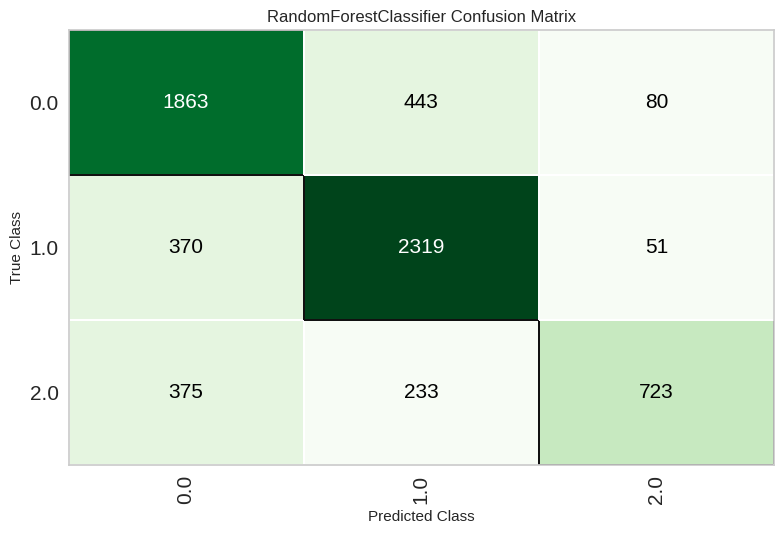

In [ ]:
plot_model(rf, plot = 'confusion_matrix')

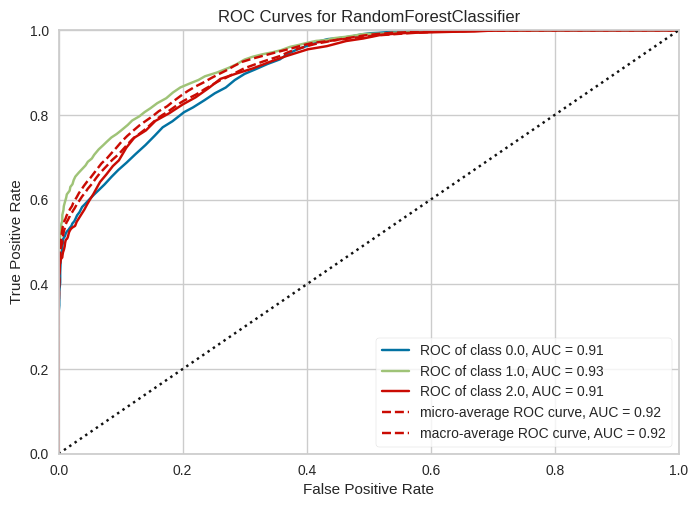

In [ ]:
plot_model(best, plot = 'auc')

## Second-step classification for non-adherent population

In [ ]:
df2 = df[df['step_one_class'] == 0]

In [ ]:
df2.head()

,member_user_id,total_visits_week_17,is_adherent,first_appointment_prev_30_day_date,first_appointment_date,last_appointment_date,member_state,member_country_code,clinician_user_id,clinician_employment_status,...,first_appt_employment_days,clinician_experience_hours,member_user_id_1,has_visits_less_4,has_visits_4_to_11,is_partial_response,has_break_in_care,region,experience_ratio,step_one_class
4,738,9,0,2022-07-12,2022-08-11,2022-11-04,Texas,US,170588,Fulltime,...,325,867.75,738,0,1,1,0.0,NOCD_region,2.67,0.0
11,1292,4,0,2022-03-23,2022-04-22,2022-05-16,UNK,UK,206035,Contract,...,130,198.50,1292,0,1,0,0.0,Other Country,1.526923,0.0
15,1894,4,0,2022-04-17,2022-05-17,2022-06-22,British Columbia,CA,175348,Contract,...,260,355.00,1894,0,1,0,0.0,Canada,1.365385,0.0
16,2214,9,0,2022-10-19,2022-11-18,2022-12-22,New York,US,286180,Fulltime,...,18,NaN,2214,0,1,0,0.0,Northeast,NaN,0.0
19,2389,5,0,2021-12-28,2022-01-27,2022-02-10,Arizona,US,145731,Contract,...,255,189.25,2389,0,1,0,0.0,NOCD_region,0.742157,0.0


In [ ]:
print(df2.shape)
# 7956 rows with non-adherent label

(7946, 115)


In [ ]:
mutual_test = df2[(df2['is_partial_response'] == 1) & (df2['has_visits_4_to_11'] == 1) & (df2['has_visits_less_4'] == 1)]
mutual_test
# 0 matching good

,member_user_id,total_visits_week_17,is_adherent,first_appointment_prev_30_day_date,first_appointment_date,last_appointment_date,member_state,member_country_code,clinician_user_id,clinician_employment_status,...,first_appt_employment_days,clinician_experience_hours,member_user_id_1,has_visits_less_4,has_visits_4_to_11,is_partial_response,has_break_in_care,region,experience_ratio,step_one_class


In [ ]:
mutual_test2 = df2[(df2['is_partial_response'] == 1) & (df2['has_visits_4_to_11'] == 1)]
mutual_test2
# 1785 rows matching

,member_user_id,total_visits_week_17,is_adherent,first_appointment_prev_30_day_date,first_appointment_date,last_appointment_date,member_state,member_country_code,clinician_user_id,clinician_employment_status,...,first_appt_employment_days,clinician_experience_hours,member_user_id_1,has_visits_less_4,has_visits_4_to_11,is_partial_response,has_break_in_care,region,experience_ratio,step_one_class
4,738,9,0,2022-07-12,2022-08-11,2022-11-04,Texas,US,170588,Fulltime,...,325,867.75,738,0,1,1,0.0,NOCD_region,2.67,0.0
31,7202,5,0,2022-01-12,2022-02-11,2022-04-01,Georgia,US,191673,Contract,...,95,101.25,7202,0,1,1,0.0,Southeast,1.065789,0.0
47,9295,4,0,2022-03-19,2022-04-18,2022-06-06,Washington,US,208633,Fulltime,...,98,73.50,9295,0,1,1,0.0,Pacific,0.75,0.0
95,14434,9,0,2022-04-12,2022-05-12,2022-08-01,UNK,UK,126872,Fulltime,...,437,965.00,14434,0,1,1,0.0,Other Country,2.208238,0.0
131,19488,6,0,2022-10-16,2022-11-15,2022-12-22,Arizona,US,78418,Contract,...,953,1843.50,19488,0,1,1,0.0,NOCD_region,1.934418,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21484,303524,7,0,2022-11-22,2022-12-22,2023-01-12,Illinois,US,292334,Fulltime,...,24,3.00,303524,0,1,1,0.0,Midwest,0.125,0.0
21490,303731,8,0,2022-11-22,2022-12-22,2023-02-08,Texas,US,123988,Fulltime,...,695,1707.00,303731,0,1,1,0.0,NOCD_region,2.456115,0.0
21497,303953,10,0,2022-11-28,2022-12-28,2023-04-03,Nebraska,US,126356,Fulltime,...,687,1447.25,303953,0,1,1,0.0,Midwest,2.106623,0.0
21520,304538,6,0,2022-11-29,2022-12-29,2023-02-16,New York,US,210289,Fulltime,...,353,849.75,304538,0,1,1,0.0,Northeast,2.407224,0.0


In [ ]:
mutual_test3 = df2[(df2['is_partial_response'] == 1) & (df2['has_visits_less_4'] == 1)]
mutual_test3
# 47 rows matching

,member_user_id,total_visits_week_17,is_adherent,first_appointment_prev_30_day_date,first_appointment_date,last_appointment_date,member_state,member_country_code,clinician_user_id,clinician_employment_status,...,first_appt_employment_days,clinician_experience_hours,member_user_id_1,has_visits_less_4,has_visits_4_to_11,is_partial_response,has_break_in_care,region,experience_ratio,step_one_class
26,6069,3,0,2022-05-14,2022-06-13,2022-06-29,California,US,203001,Contract,...,189,357.25,6069,1,0,1,0.0,Pacific,1.890212,0.0
1849,175411,3,0,2022-01-02,2022-02-01,2022-03-10,California,US,109892,Contract,...,462,884.00,175411,1,0,1,0.0,Pacific,1.91342,0.0
2657,205544,3,0,2022-08-15,2022-09-14,2022-10-03,Texas,US,112760,Contract,...,653,1115.50,205544,1,0,1,0.0,NOCD_region,1.70827,0.0
3243,213331,3,0,2021-12-11,2022-01-10,2022-02-08,New Jersey,US,128247,Fulltime,...,341,765.75,213331,1,0,1,0.0,Northeast,2.245601,0.0
4251,219096,3,0,2022-09-07,2022-10-07,2022-10-27,Illinois,US,112161,Fulltime,...,683,1147.50,219096,1,0,1,0.0,Midwest,1.680088,0.0
5130,223568,3,0,2022-01-18,2022-02-17,2022-03-03,Michigan,US,121986,Fulltime,...,402,1020.00,223568,1,0,1,0.0,Midwest,2.537313,0.0
5351,224532,2,0,2022-01-22,2022-02-21,2022-03-12,Maryland,US,138588,Fulltime,...,329,693.00,224532,1,0,1,0.0,Northeast,2.106383,0.0
5655,225924,2,0,2022-02-26,2022-03-28,2022-04-19,Washington,US,204593,Fulltime,...,83,152.75,225924,1,0,1,0.0,Pacific,1.840361,0.0
6277,228836,3,0,2022-03-07,2022-04-06,2022-05-02,California,US,232179,Fulltime,...,16,2.50,228836,1,0,1,0.0,Pacific,0.15625,0.0
6278,228836,3,0,2022-03-07,2022-04-06,2022-05-02,California,US,232179,Fulltime,...,16,2.50,228836,1,0,1,0.0,Pacific,0.15625,0.0


In [ ]:
mutual_test4 = df2[(df2['has_visits_4_to_11'] == 1) & (df2['has_visits_less_4'] == 1)]
mutual_test4
# 0 rows, good

,member_user_id,total_visits_week_17,is_adherent,first_appointment_prev_30_day_date,first_appointment_date,last_appointment_date,member_state,member_country_code,clinician_user_id,clinician_employment_status,...,first_appt_employment_days,clinician_experience_hours,member_user_id_1,has_visits_less_4,has_visits_4_to_11,is_partial_response,has_break_in_care,region,experience_ratio,step_one_class


In [ ]:
# Recoding rows without mutual exclusivity, also removing 781 missing for now until we figure that out
df_me = df2.copy()
def recode_values(df_me):
    df_me.loc[(df_me['is_partial_response'] == 1) & (df['has_visits_4_to_11'] == 1), 'has_visits_4_to_11'] = 0
    df_me.loc[(df_me['is_partial_response'] == 1) & (df['has_visits_less_4'] == 1), 'has_visits_less_4'] = 0
    return df_me

df_me_recoded = recode_values(df_me)
print(df_me_recoded)

       member_user_id  total_visits_week_17  is_adherent  \
4                 738                     9            0   
11               1292                     4            0   
15               1894                     4            0   
16               2214                     9            0   
19               2389                     5            0   
...               ...                   ...          ...   
21524          304660                    11            0   
21525          304938                     3            0   
21528          304999                     8            0   
21531          305246                     6            0   
21533          305328                     4            0   

      first_appointment_prev_30_day_date first_appointment_date  \
4                             2022-07-12             2022-08-11   
11                            2022-03-23             2022-04-22   
15                            2022-04-17             2022-05-17   
16         

In [ ]:
tests = df_me_recoded[(df2['is_partial_response'] == 1) & (df_me_recoded['has_visits_4_to_11'] == 1)]
tests
# 0 now which is good

,member_user_id,total_visits_week_17,is_adherent,first_appointment_prev_30_day_date,first_appointment_date,last_appointment_date,member_state,member_country_code,clinician_user_id,clinician_employment_status,...,first_appt_employment_days,clinician_experience_hours,member_user_id_1,has_visits_less_4,has_visits_4_to_11,is_partial_response,has_break_in_care,region,experience_ratio,step_one_class


In [ ]:
df_me_recoded['step_two_class'] = np.where(df_me_recoded['has_visits_less_4'] == 1, 0, # didn't engage = 0
                                np.where(df_me_recoded['has_visits_4_to_11'] == 1, 1, np.nan))

In [ ]:
# Checking value counts
df_me_recoded['step_two_class'].value_counts(dropna=False)

1.0    4208
NaN    2611
0.0    1127
Name: step_two_class, dtype: int64

In [ ]:
df_me_recoded['step_two_class'] = np.where(df_me_recoded['is_partial_response'] == 1, 2, df_me_recoded['step_two_class'])

In [ ]:
df_me_recoded['step_two_class'].value_counts(dropna=False)

1.0    4208
2.0    1830
0.0    1127
NaN     781
Name: step_two_class, dtype: int64

In [ ]:
# Let's drop the 781 missing for now
dfmer0 = df_me_recoded.copy()
dfmer1 = dfmer0.dropna(subset=['step_two_class'])
dfmer1['step_two_class'].value_counts(dropna=False)

1.0    4208
2.0    1830
0.0    1127
Name: step_two_class, dtype: int64

In [ ]:
df20 = dfmer1[['step_two_class', 'member_country_code', 'clinician_user_id',
       'clinician_employment_status', 'clinician_licensing_level',
       'clinician_star_rating', 'current_clinician_role',
       'age_at_therapy_start', 'member_gender', 'bg_ocd_criteria_time_years',
       'billing_plan', 'pre_therapy_posts', 'pre_therapy_appopens',
       'pre_therapy_cancellations', 'pre_therapy_member_messages',
       'pre_therapy_clinician_messages', 'visits_total', 'docs_count',
       'docs_severity', 'first_docs_severity', 'docs_contamination',
       'first_docs_contamination', 'docs_symmetry', 'first_docs_symmetry', 'docs_responsibility', 'first_docs_responsibility', 'docs_unacceptable_thoughts', 'first_docs_unacceptable_thoughts',
       'qles_count', 'qles_total',
       'first_qles_total', 'diamond_count', 'diamond_distress_score',
       'first_diamond_distress_score', 'diamond_functional_score',
       'first_diamond_functional_score', 'diamond_funct_imprmnt_avg',
       'dass_count', 'dass_anxiety', 'first_dass_anxiety', 'dass_total',
       'first_dass_total', 'dass_depression', 'first_dass_depression',
       'dass_stress', 'first_dass_stress', 'visits', 'cancellations_total',
       'cancellations', 'member_messages_total', 'clinician_messages_total',
       'member_messages', 'clinician_messages', 'posts_total', 'posts',
       'ratings_count_total', 'ratings_average', 'ratings_latest',
       'ratings_count', 'opens', 'obsessions_total', 'exposures_total',
       'erp_total', 'erp_minutes_total', 'obsessions', 'exposures', 'erp',
       'erp_minutes', 'region', 'first_episode_type', 'bg_medication_status', 'co_morbid','first_appt_employment_days','experience_ratio']]
df20.describe()

,step_two_class,clinician_user_id,age_at_therapy_start,bg_ocd_criteria_time_years,pre_therapy_posts,pre_therapy_appopens,pre_therapy_cancellations,pre_therapy_member_messages,pre_therapy_clinician_messages,visits_total,...,exposures_total,erp_total,erp_minutes_total,obsessions,exposures,erp,erp_minutes,co_morbid,first_appt_employment_days,experience_ratio
count,7165.000000,6885.0,7165.0,7165.0,1865.0,7145.0,6876.0,7165.0,7165.0,7165.0,...,7165.0,7165.0,7165.000000,7165.0,7165.0,7165.0,7165.000000,7165.000000,6885.0,6885.0
mean,1.098116,174888.811329,27.943196,0.0,4.319571,7.703009,0.23662,1.351849,3.622749,3.202512,...,2.879414,0.284997,4.316869,0.614375,1.313329,0.149477,1.729986,0.660991,317.949601,<NA>
std,0.634925,54122.381422,10.901262,0.0,19.746809,13.975121,0.548985,2.962401,3.911487,1.285097,...,5.537444,1.814931,53.091986,1.526132,3.551951,0.919643,22.126641,0.473406,236.06691,<NA>
min,0.000000,52369.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,-468.0,<NA>
25%,1.000000,126872.0,21.0,0.0,0.0,2.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,119.0,<NA>
50%,1.000000,185508.0,26.0,0.0,0.0,4.0,0.0,0.0,2.0,3.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000,277.0,<NA>
75%,2.000000,210289.0,33.0,0.0,2.0,9.0,0.0,1.0,5.0,4.0,...,4.0,0.0,0.000000,0.0,1.0,0.0,0.000000,1.000000,470.0,<NA>
max,2.000000,335758.0,80.0,0.0,396.0,351.0,5.0,44.0,41.0,9.0,...,105.0,49.0,1753.033333,21.0,105.0,20.0,1209.966667,1.000000,1159.0,<NA>


In [ ]:
# import pycaret classification and init setup
from pycaret.classification import *
s = setup(df20, target = 'step_two_class', session_id = 123)

,Description,Value
0,Session id,123
1,Target,step_two_class
2,Target type,Multiclass
3,Original data shape,"(7165, 74)"
4,Transformed data shape,"(7165, 118)"
5,Transformed train set shape,"(5015, 118)"
6,Transformed test set shape,"(2150, 118)"
7,Ordinal features,2
8,Numeric features,63
9,Categorical features,10


In [ ]:
# Step 2
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7729,0.8933,0.7729,0.7974,0.7562,0.5466,0.5817,2.4580
lightgbm,Light Gradient Boosting Machine,0.7707,0.8872,0.7707,0.7707,0.7618,0.5653,0.5762,2.5770
catboost,CatBoost Classifier,0.7683,0.8881,0.7683,0.7685,0.7593,0.5608,0.5717,19.7030
et,Extra Trees Classifier,0.7675,0.8878,0.7675,0.7951,0.7485,0.5321,0.5720,2.2890
xgboost,Extreme Gradient Boosting,0.7627,0.8876,0.7627,0.7598,0.7556,0.5566,0.5633,10.1580
dt,Decision Tree Classifier,0.7131,0.7486,0.7131,0.7158,0.7139,0.4966,0.4971,0.8770
gbc,Gradient Boosting Classifier,0.6824,0.8130,0.6824,0.6902,0.6487,0.3471,0.3854,9.5440
ridge,Ridge Classifier,0.6050,0.0000,0.6050,0.5853,0.5303,0.1319,0.1747,0.7610
lda,Linear Discriminant Analysis,0.6038,0.6810,0.6038,0.5792,0.5511,0.1711,0.1992,0.7480
lr,Logistic Regression,0.5892,0.5556,0.5892,0.4312,0.4531,0.0221,0.0482,2.6250


Processing:   0%|          | 0/69 [00:00<?, ?it/s]